# Investigating Factors of Rising House Values in New York City: Step 3: Machine Learning

Team Members: Francisco Brady (fbrady), Zhonghan Xie (jonasxie), Michael Garner (mngarner)  
Date: 2024-12-02

## Introduction

In this section, we seek to apply clustering machine learning techniques to the combined New York City housing price, education, eviction, and demographic dataset in order to identify patterns and relationships between these phenomena. Specifically, we are interested in seeing if we can identify clusters of neighborhoods that have similar characteristics in these metrics i.e. if neighborhoods with certain attendance and eviction rates tend to have higher/lower housing prices or demographic characteristics. 

This analysis will augment the trends and hypothesis testing carried out in step 2 of this project, which in general indicated that neighborhoods with higher housing prices and a higher percentage of white residents tended to have lower schoolchild absenteeism and housing eviction rates, and vice versa. We expect clusters to underscore this relationship further.

In [205]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [206]:
# Import merged neighborhood-level dataset
allData = pd.read_csv('./data/analytic_dataset.csv')

## Preprocessing


In [207]:
# Streamline dataset to keep columns of interest for this analysis
keepCols = ['year', 'nta_name', 'borough', 'pct_attendance',
       'pct_chronically_absent', 'EVICTION_COUNT', 'GEOID',
       'median_sale_price', 'hvi', 'total_population',
       'median_income', 'white_pct', 'black_pct',
       'american_indian_alaska_native_pct', 'asian_pct',
       'hawaiian_pacific_islander_pct', 'multiple_race_pct', 'other_race_pct']
data = allData[keepCols]

# Rename column for format
data.rename(columns={'EVICTION_COUNT': 'num_evictions'}, inplace=True)

# Drop rows with missing values
data = data.dropna()
data.sample(5)

C:\Users\Michael Garner\AppData\Local\Temp\ipykernel_13944\790246251.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'EVICTION_COUNT': 'num_evictions'}, inplace=True)


,year,nta_name,borough,pct_attendance,pct_chronically_absent,num_evictions,GEOID,median_sale_price,hvi,total_population,median_income,white_pct,black_pct,american_indian_alaska_native_pct,asian_pct,hawaiian_pacific_islander_pct,multiple_race_pct,other_race_pct
29266,2020.0,East Harlem (South),Manhattan,92.811897,25.954199,2.0,36061017000,1634587.0,857331.335748,8100.0,28034.0,34.704,18.370,2.543,24.679,0.0,10.321,14.543
53623,2019.0,Port Richmond,Staten Island,84.292732,39.814243,8.0,36085024700,512500.0,481196.780912,3163.0,40427.0,40.247,19.981,0.000,19.791,0.0,6.513,16.725
15490,2020.0,Bedford-Stuyvesant (East),Brooklyn,89.898216,41.628960,4.0,36047038300,1320000.0,905406.301449,4737.0,42608.0,18.830,66.308,0.274,7.515,0.0,8.613,2.765
11483,2022.0,Marine Park-Mill Basin-Bergen Beach,Brooklyn,93.697762,19.020979,1.0,36047069601,990000.0,761046.690885,3114.0,40716.0,45.890,43.802,0.000,2.697,0.0,9.120,3.051
41098,2022.0,Baisley Park,Queens,88.647041,43.765282,3.0,36081028000,580000.0,631038.770533,1589.0,38056.0,3.084,83.008,0.000,4.468,0.0,2.517,8.181


In [208]:
# Reshape data to have one row per neighborhood
# Take evictions, hvi, and median sale price and reshape by year
# Aggregate all other columns by mean

# Convert year to a no-decimal string before reshaping
data['year'] = data['year'].astype(int).astype(str)

# Define function to pull variables and reshape to wide format, interpolate missing values
def reshape_data(data, value_col, index_col, columns_col):
    # Create the pivot table
    data_pivot = data.pivot_table(index=[index_col], columns=columns_col, values=value_col)
    # Interpolate missing values
    data_pivot = data_pivot.interpolate(method='linear', axis=1)    
    data_pivot.reset_index(inplace=True)    
    # Rename columns to include the value_col prefix for clarity
    data_pivot.columns = [index_col] + [f'{value_col}_{col}' for col in data_pivot.columns[1:]]    
    return data_pivot


In [209]:
evict_pivot = reshape_data(data, 'num_evictions', 'nta_name', 'year')
hvi_pivot = reshape_data(data, 'hvi', 'nta_name', 'year')
sale_price_pivot = reshape_data(data, 'median_sale_price', 'nta_name', 'year')

In [210]:
# Collapse to one row for each neighborhood
data.drop(columns=['GEOID'], inplace=True)
data = data.groupby(['nta_name', 'borough']).agg({
    'pct_attendance': 'mean',
    'pct_chronically_absent': 'mean',
    'total_population': 'mean',
    'median_income': 'mean',
    'white_pct': 'mean',
    'black_pct': 'mean',
    'american_indian_alaska_native_pct': 'mean',
    'asian_pct': 'mean',
    'hawaiian_pacific_islander_pct': 'mean',
    'multiple_race_pct': 'mean',
    'other_race_pct': 'mean'
}).reset_index()


In [211]:
# Merge in reshaped data
data = data.merge(evict_pivot, on='nta_name', how='left')
data = data.merge(hvi_pivot, on='nta_name', how='left')
data = data.merge(sale_price_pivot, on='nta_name', how='left')

In [212]:
data.head()

,nta_name,borough,pct_attendance,pct_chronically_absent,total_population,median_income,white_pct,black_pct,american_indian_alaska_native_pct,asian_pct,...,num_evictions_2021,num_evictions_2022,hvi_2019,hvi_2020,hvi_2021,hvi_2022,median_sale_price_2019,median_sale_price_2020,median_sale_price_2021,median_sale_price_2022
0,Annadale-Huguenot-Prince's Bay-Woodrow,Staten Island,90.908173,26.137263,6365.833333,51494.666667,93.866917,1.808000,0.000000,2.430167,...,1.000000,1.25,555499.363294,550402.839163,565244.293110,617570.552311,795000.0,769000.0,825000.0,929500.0
1,Astoria (Central),Queens,93.794789,19.178189,4200.217391,53675.130435,62.310522,2.515783,0.984913,17.909304,...,1.000000,1.50,810890.207402,790067.820665,768519.860276,771594.666048,1157500.0,1300000.0,1200000.0,1248000.0
2,Astoria (East)-Woodside (North),Queens,91.716040,26.626202,2675.125000,38265.083333,59.745375,5.943583,0.286042,16.515625,...,1.757143,1.80,810890.207402,790067.820665,780831.243356,771594.666048,1157500.0,1300000.0,1274000.0,1248000.0
3,Astoria (North)-Ditmars-Steinway,Queens,93.550828,20.996938,3189.500000,48089.607143,72.516250,3.075250,0.215893,9.791071,...,1.466667,1.60,810890.207402,790067.820665,780831.243356,771594.666048,1157500.0,1300000.0,1274000.0,1248000.0
4,Baisley Park,Queens,86.424383,44.085725,2206.869565,32745.847826,5.066826,68.072326,0.117739,7.896174,...,1.500000,2.00,405046.524528,418482.728411,423075.233739,425119.568484,635000.0,631325.0,680000.0,580000.0


In [213]:
# Add column to categorize white/minority-dominated neighborhoods
data['minority_dominated'] = np.where((100 - data['white_pct']) > 50, "Yes", "No")
data.sample(5)

,nta_name,borough,pct_attendance,pct_chronically_absent,total_population,median_income,white_pct,black_pct,american_indian_alaska_native_pct,asian_pct,...,num_evictions_2022,hvi_2019,hvi_2020,hvi_2021,hvi_2022,median_sale_price_2019,median_sale_price_2020,median_sale_price_2021,median_sale_price_2022,minority_dominated
3,Astoria (North)-Ditmars-Steinway,Queens,93.550828,20.996938,3189.500000,48089.607143,72.516250,3.075250,0.215893,9.791071,...,1.600000,8.108902e+05,7.900678e+05,7.808312e+05,7.715947e+05,1157500.0,1300000.0,1274000.0,1248000.0,No
45,East Williamsburg,Brooklyn,86.875673,42.600989,3646.206897,39272.172414,52.234034,14.912310,1.420448,9.327034,...,3.333333,9.468295e+05,9.236813e+05,9.797759e+05,1.035870e+06,1816425.0,1875000.0,1887500.0,1900000.0,No
128,Upper East Side-Yorkville,Manhattan,91.544241,22.317137,5828.277778,75293.555556,80.511167,4.391833,0.000000,8.527806,...,2.461538,1.432972e+06,1.370688e+06,1.437708e+06,1.522323e+06,9872500.0,8150000.0,7900000.0,8675000.0,No
52,Fort Greene,Brooklyn,85.902844,43.296450,3458.240000,49744.040000,41.852920,31.532640,0.478160,10.067200,...,1.500000,1.258829e+06,1.224279e+06,1.219689e+06,1.295057e+06,2575000.0,2604977.0,2682500.0,2800000.0,Yes
71,Kew Gardens Hills,Queens,92.750956,20.614857,3980.277778,35537.111111,52.777444,11.270000,0.573667,23.702333,...,3.500000,6.347272e+05,5.861337e+05,5.656561e+05,5.451784e+05,1093950.0,855000.0,977500.0,1100000.0,No


In [214]:
# Separate data into features and a label
X = data.drop(['nta_name'], axis=1)
y = data['nta_name']

In [215]:
# Build preprocessing pipelines
catCols = ['borough', 'minority_dominated']
numCols = X.columns.drop(catCols)
numPC = 4 # Number of principal components to use

# Numerical variable pipeline
numPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define column transformer
preprocessor = ColumnTransformer([
    ('num', numPipe, numCols),
    ('cat', OneHotEncoder(), catCols)
])

# Pipeline with dimension reduction
fullPipe = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=numPC))
])

In [216]:
# Fit and transform features
X_pca = fullPipe.fit_transform(X)

In [217]:
# Report percent of variance explained by PCA with 4 components
evr = fullPipe.named_steps['pca'].explained_variance_ratio_
print(f"Percent variance retained in first {numPC} PCs: {100*evr}%")
print(f"Sum of percent variance explained by first 4 PCs: {100*sum(evr):.2f}%")

Percent variance retained in first 4 PCs: [37.54465707 17.53298024  8.56416373  5.43434603]%
Sum of percent variance explained by first 4 PCs: 69.08%


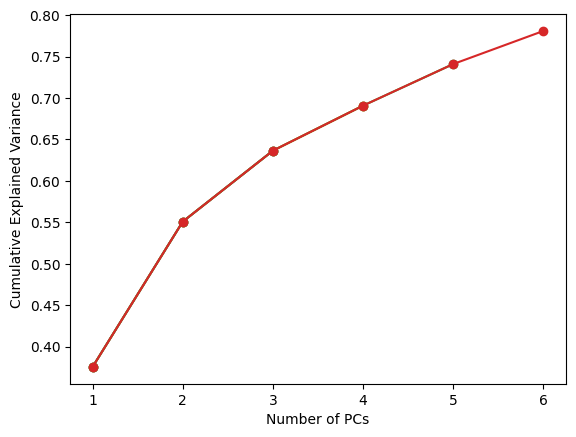

In [218]:
# Try different number of principal components to finetune the PCA model
for numPC in range(3,7):
    fullPipe.named_steps['pca'].n_components = numPC
    X_pca = fullPipe.fit_transform(X)
    evr = fullPipe.named_steps['pca'].explained_variance_ratio_
    plt.plot(range(1, numPC+1), np.cumsum(evr), marker="o", label=f'{numPC} PCs')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [219]:
# Report percent of variance explained by PCA with 4 components: chosen number of components
fullPipe.named_steps['pca'].n_components = 4
X_pca = fullPipe.fit_transform(X)
evr = fullPipe.named_steps['pca'].explained_variance_ratio_
print(f"Percent variance retained in first {numPC} PCs: {100*evr}%")
print(f"Sum of percent variance explained by first 5 PCs: {100*sum(evr):.2f}%")

Percent variance retained in first 6 PCs: [37.54465707 17.53298024  8.56416373  5.43434603]%
Sum of percent variance explained by first 5 PCs: 69.08%


### Preprocessing

First we load the analytic dataset used in prior steps. This data is a cross-sectional dataset of Census tracts in New York City, aggregated to the neighborhood level, from 2019 through 2022. The dataset includes demographic data, median income, school attendance data, and counts of evictions in those years.

The data is in long format, with years repeating for each Census tract. In order to retain information, we define a function to reshape specific variables into wide format. This function is applied to the eviction counts, Home Value Index, and Sales Price variables. For missing values, the function uses a linear interpolation method to fill in the gaps. After reshaping, the data is merged back into an aggregated dataset, resulting in a wide format dataset with one row per Neighborhood.

To improve clustering, we also use the demographic data to create a categorical variable that indicates whether a neighborhood is minority dominated. A neighborhood is considered minority dominated if the percentage of minority residents is greater than 50%.

### Preprocessing Pipeline

After the initial reshaping and creation of new variables, the data can be standardized and prepared for modeling. We use the `SimpleImputer` function from the `sklearn.impute` module to fill in missing values with their median. We then use the `StandardScaler` function to standardize the numeric data, and the `OneHotEncoder` to binarize the categorical variables.

### Principal Component Analysis

We use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset. This is done by projecting the data onto a lower-dimensional space, while retaining as much variance as possible. We use the `PCA` function from the `sklearn.decomposition` module to perform PCA. The number of components is chosen based on the cumulative explained variance ratio. 

Showing the cumulative explained variance ratio for each number of components, we can determine the optimal number of components to use. Evaluating this for various numbers of components, we chose to use 4 components, capturing about 70% of the variance in the data. This number of components is the "elbow" of the diminishing returns with increasing numbers of components. This is relatively good coverage to proceed with clustering.

## Clustering Analysis


Goal of Clustering Analysis: 

Identify patterns and relationships between housing prices, education, eviction rates, and demographics in New York City to determine if neighborhoods tend to cluster together based on certain factors in the data (school attendance, housing prices, evictions, demographics).

Clustering was chosen over classification because for the purposes of this project, we are not interested in predicting a specific outcome, but rather in identifying the groups of neighborhoods that share similar characteristics, and what those characteristics are, to confirm or refute the trends observed in previous analysis and EDA.

Based on the statistical analysis performed in part 2 of this project, we expect to see two types of neighborhood clusters:
1. High housing prices, low chronic absenteeism / high school attendance, low eviction counts, and white-dominated demographic composition.
2. Low housing prices, high chronic absenteeism / low school attendance, high eviction counts, and minority-dominated demographic composition.

### Agglomerative Clustering

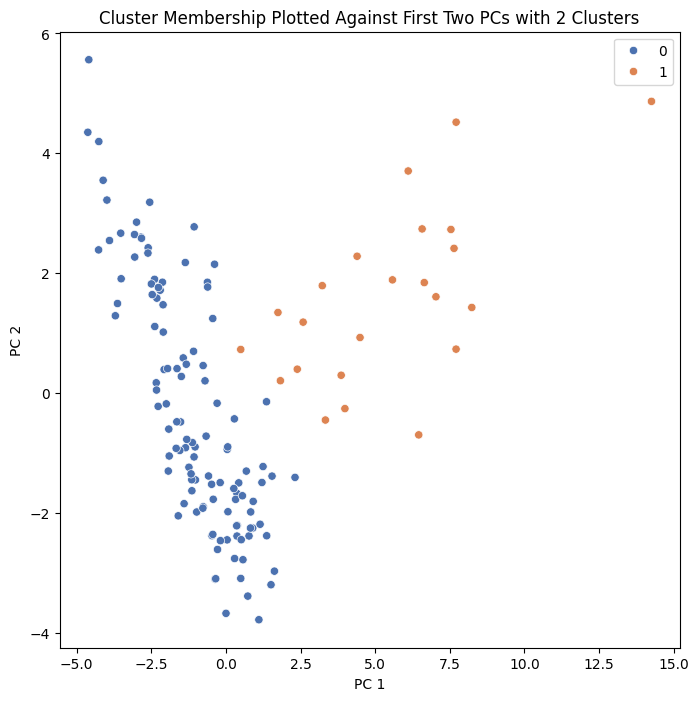

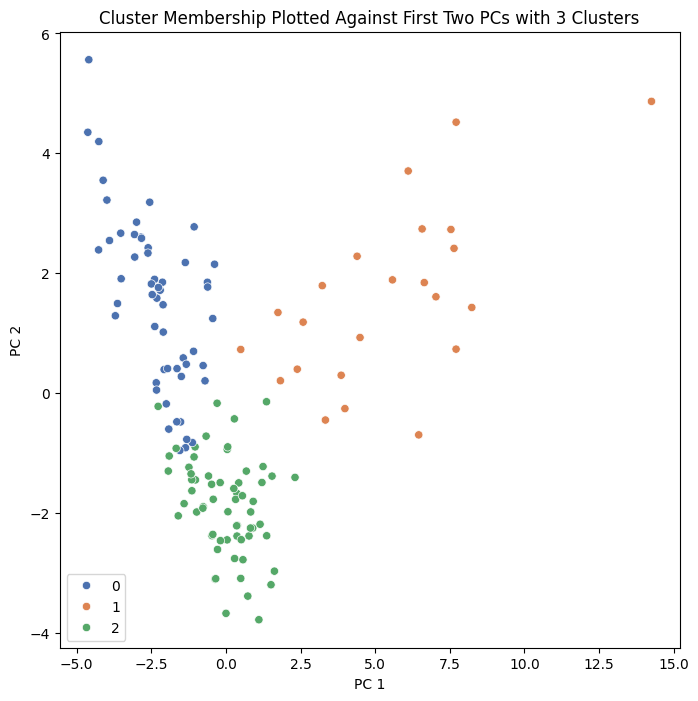

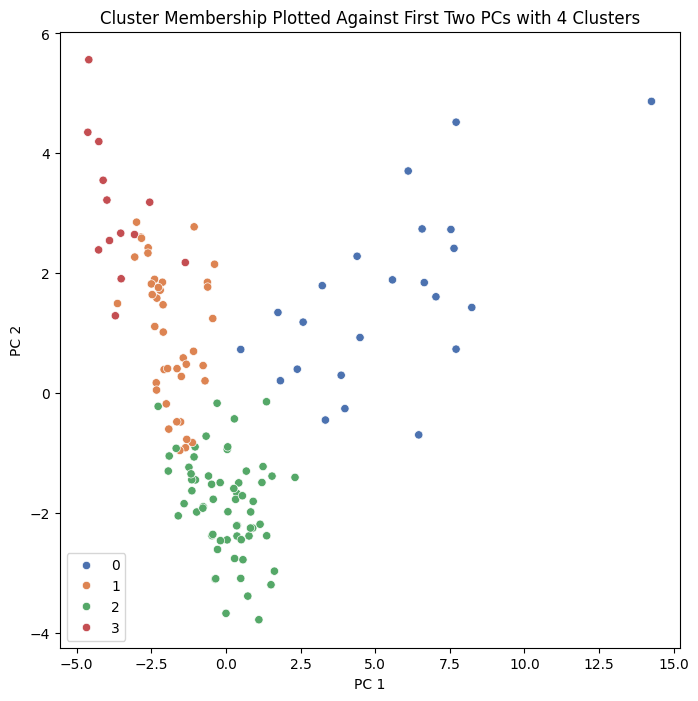

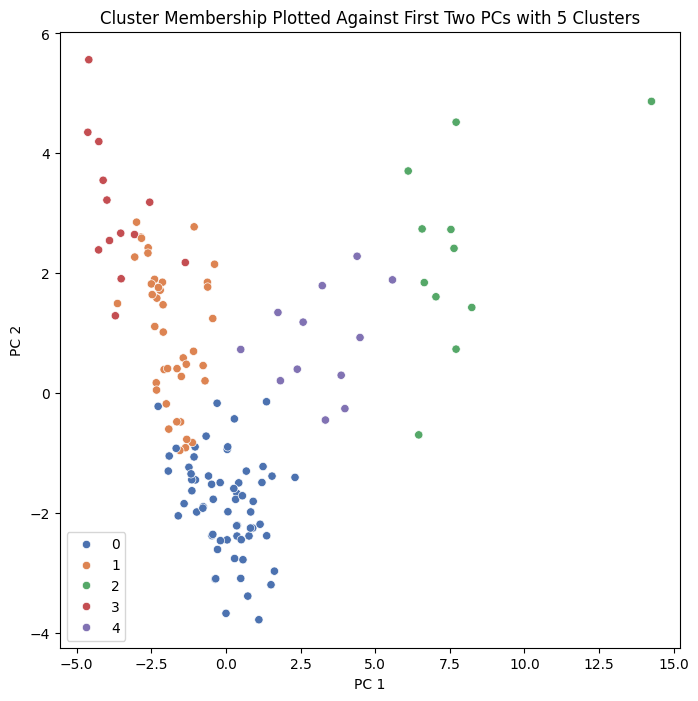

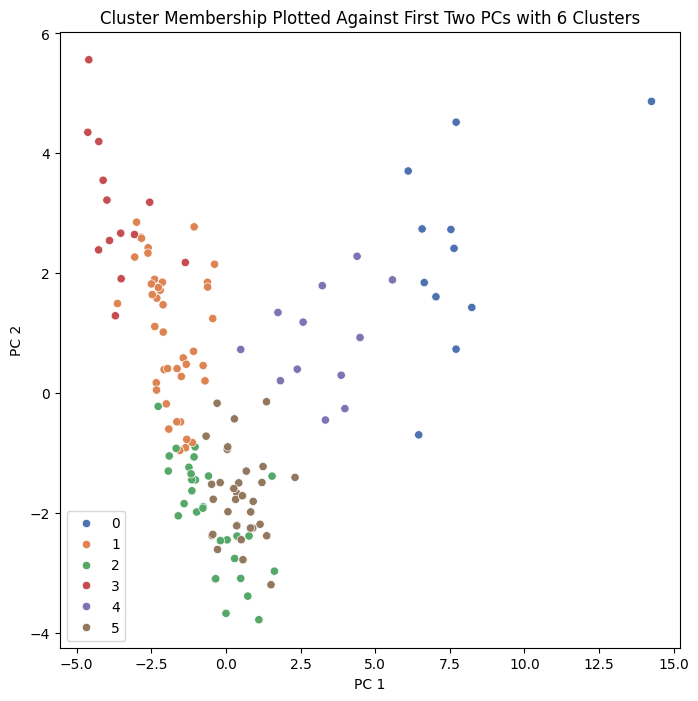

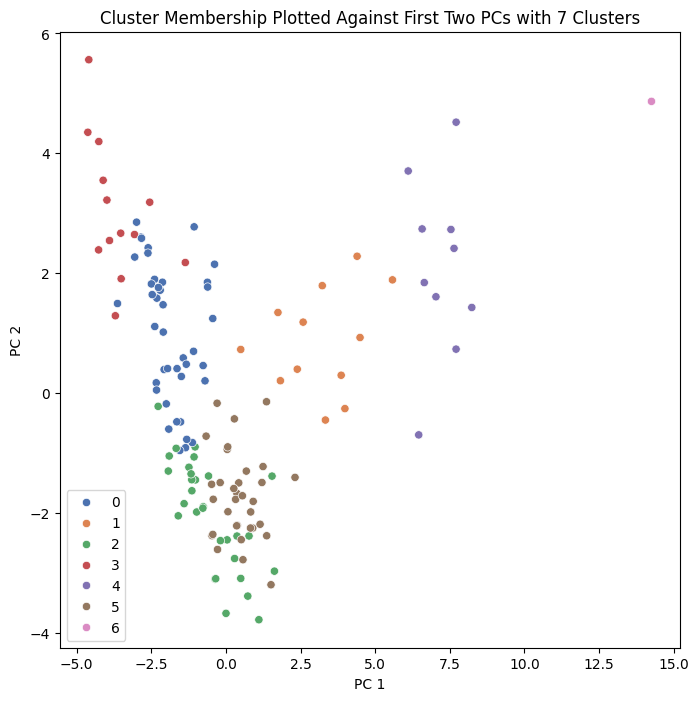

In [220]:
# Agglomerative Clustering
for numClusters in range(2, 8):
    agg = AgglomerativeClustering(n_clusters=numClusters)
    aggClusters = agg.fit_predict(X_pca)
    # Plot first two PCs with cluster assignments
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=aggClusters, palette='deep')
    plt.title(f"Cluster Membership Plotted Against First Two PCs with {numClusters} Clusters")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()

In [222]:
# Get cluster assignments for optimal number of clusters
numClustersOpt = 2
aggOpt = AgglomerativeClustering(n_clusters=numClustersOpt)
aggClusters = aggOpt.fit_predict(X_pca)

# Add cluster assignments to data and group
X_clusters = X.copy()
X_clusters.drop(columns=catCols, inplace=True)
X_clusters["ClusterNumber"] = aggClusters
X_clusters.groupby("ClusterNumber").mean().T

ClusterNumber,0,1
pct_attendance,9.099564e+01,8.948063e+01
pct_chronically_absent,3.036238e+01,3.238746e+01
total_population,3.965574e+03,5.009218e+03
median_income,3.343547e+04,7.654138e+04
white_pct,3.746705e+01,6.953707e+01
black_pct,2.608896e+01,8.937080e+00
american_indian_alaska_native_pct,4.772864e-01,2.237707e-01
asian_pct,1.442211e+01,1.147369e+01
hawaiian_pacific_islander_pct,6.028614e-02,4.271726e-02
multiple_race_pct,1.092947e+01,1.107881e+01


Based on the structure of the data, we would not expect that agglomerative clustering would be the best choice. However, we can still carry it out to see what groupings we may identify.

From plotting the neighborhoods in a two-dimensional reduced space for various numbers of clusters, we can see that the neighborhoods do not tend to cluster particularly well, but it can be argued that two clusters is the optimal and most distinct grouping. Adding cluster assignments to the dataset, we can then examine the characteristics of each cluster. This reveals two clusters:

1. Cluster 0: Low-income, minority-dominated, high eviction rate, low housing value.
2. Cluster 1: The opposite i.e. high-income, white-dominated, low eviction rate, high housing value.

There was no significant difference in school attendance, indicating that this clustering method is likely not the best choice. However, most of the trends agree with previous analysis, so this clustering analysis was still informative.

### K-Means Clustering

In [223]:
silhouetteScores = []
fullPipe.named_steps['pca'].n_components = 4
X_pca = fullPipe.fit_transform(X)

for n_clusters in range(2, 8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusterLabels = kmeans.fit_predict(X_pca)
    silhouetteScore = silhouette_score(X_pca, clusterLabels)
    silhouetteScores.append(silhouetteScore)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouetteScore)
    
# Report clustering with best silhouette score
print("The best silhouette score is", max(silhouetteScores),
        "using", silhouetteScores.index(max(silhouetteScores)) + 2, "clusters")

For n_clusters = 2 The average silhouette_score is : 0.4901942914074016
For n_clusters = 3 The average silhouette_score is : 0.3792030352138077
For n_clusters = 4 The average silhouette_score is : 0.337496829662413
For n_clusters = 5 The average silhouette_score is : 0.29510770925465324
For n_clusters = 6 The average silhouette_score is : 0.3540718265088927
For n_clusters = 7 The average silhouette_score is : 0.3371597312342755
The best silhouette score is 0.4901942914074016 using 2 clusters


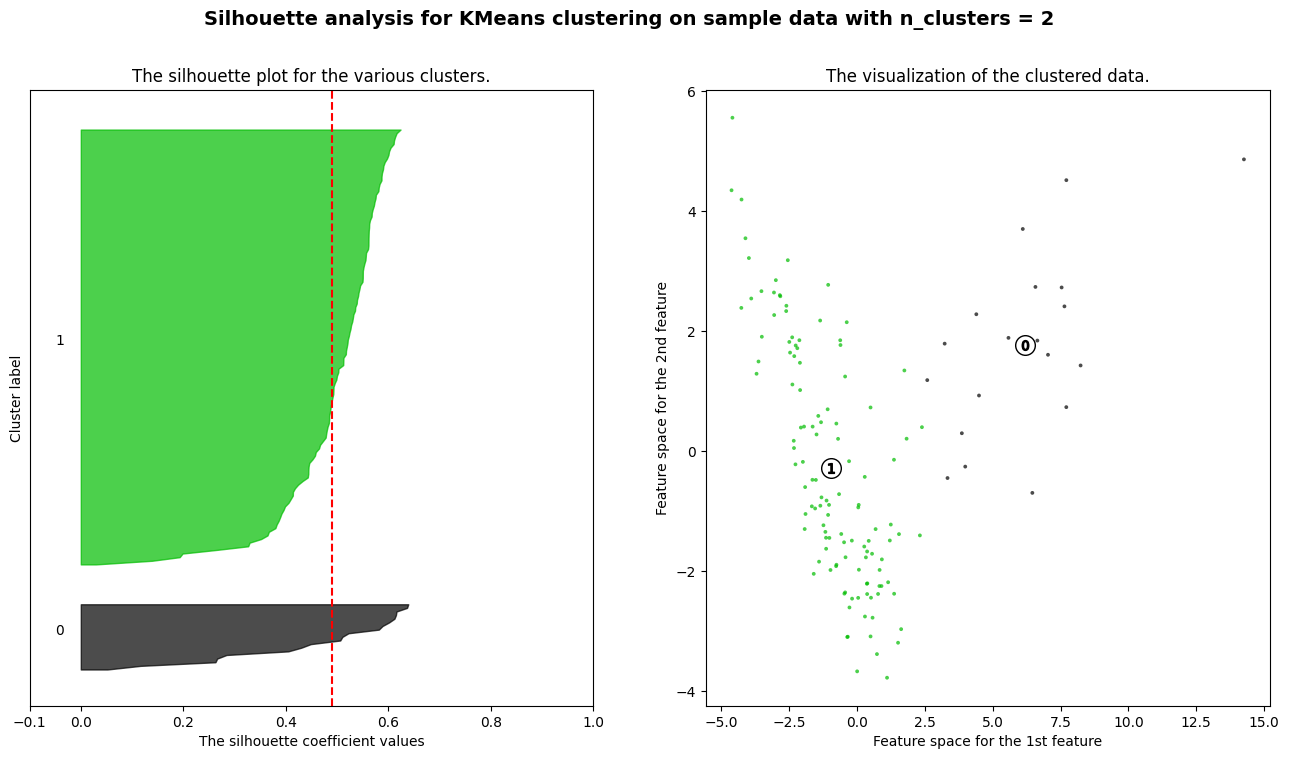

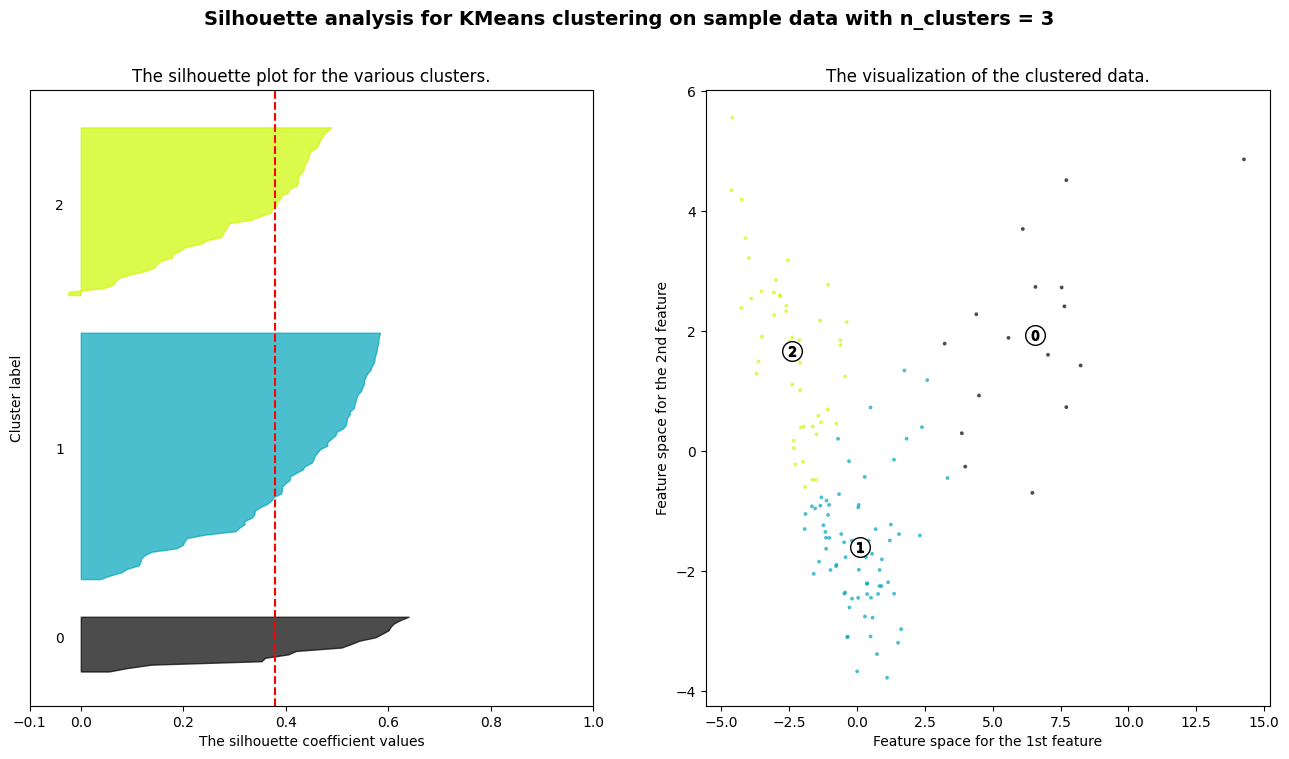

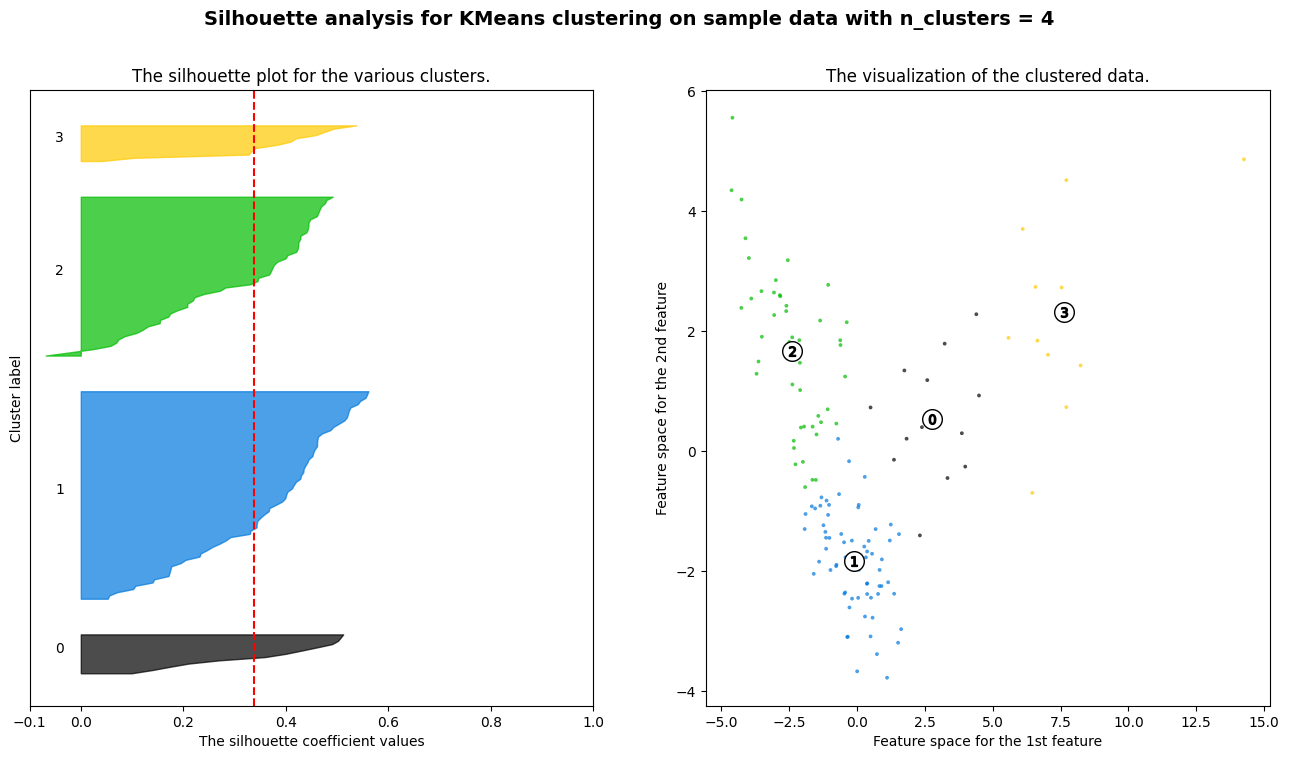

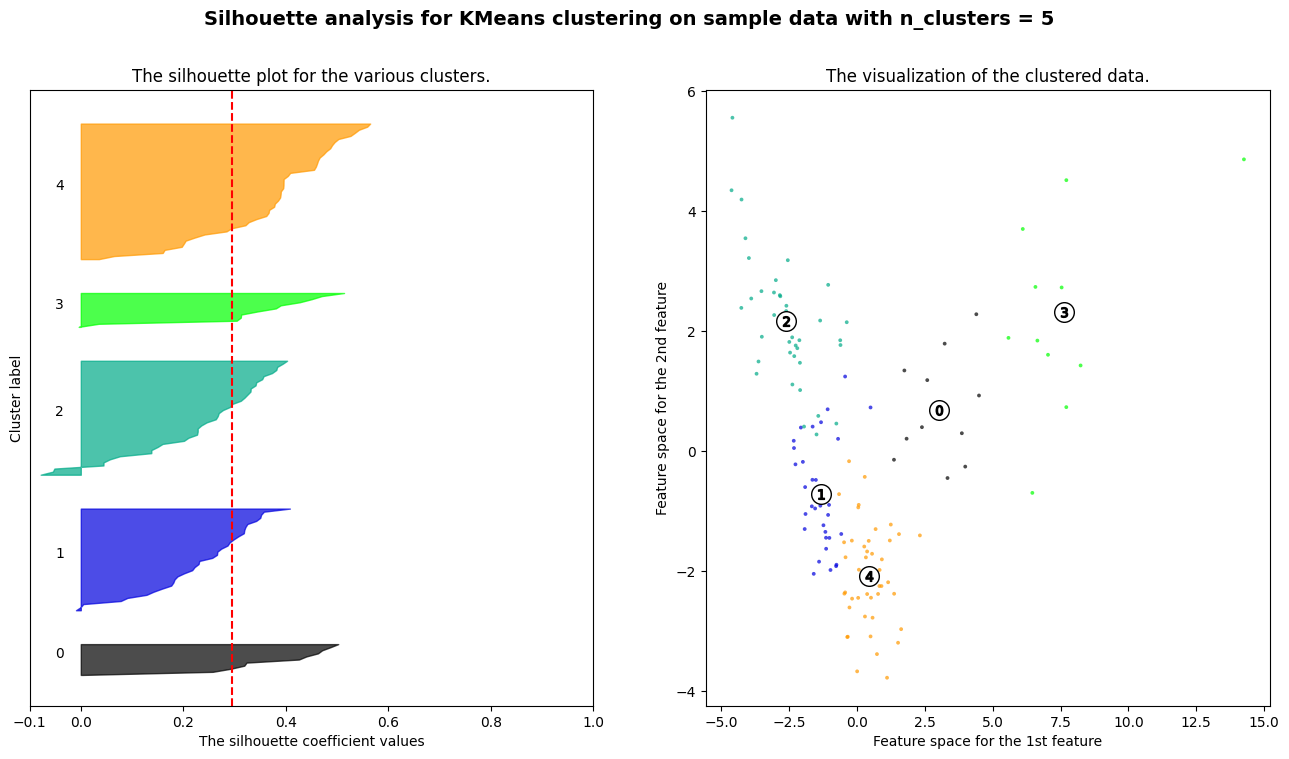

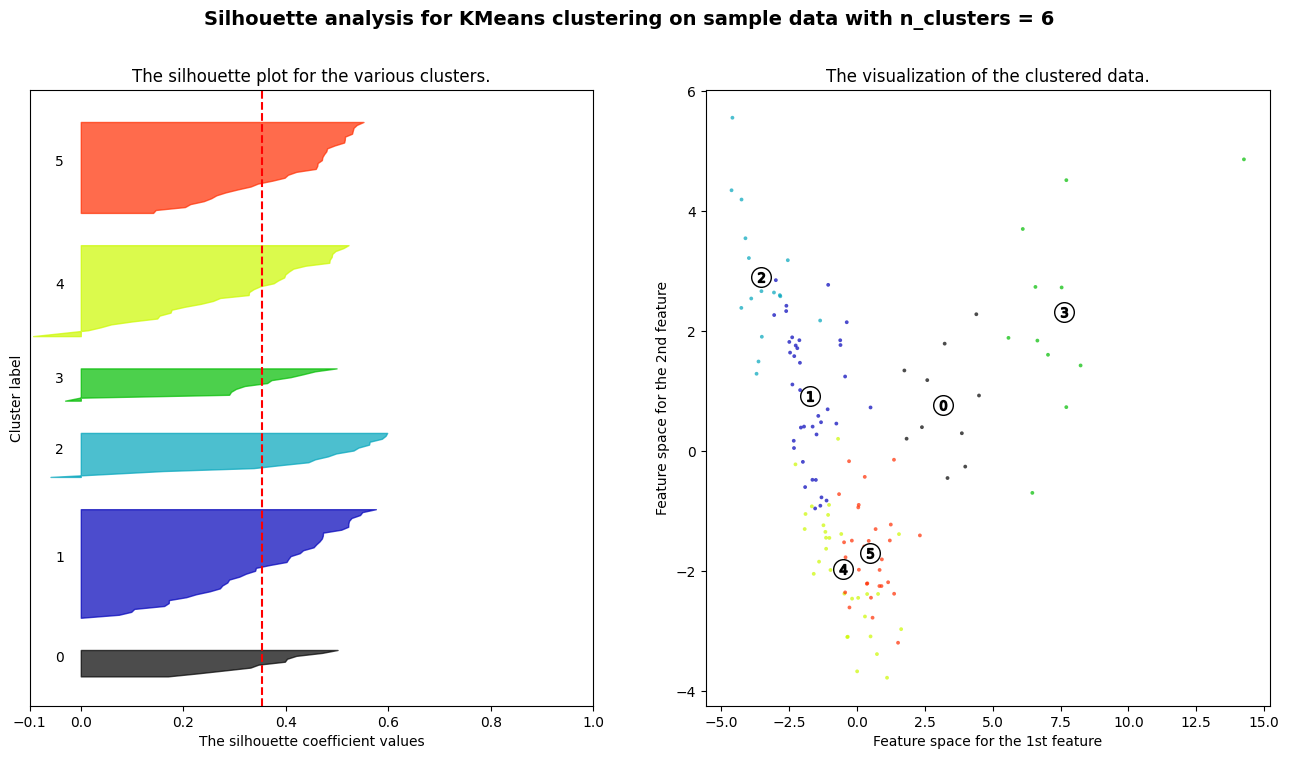

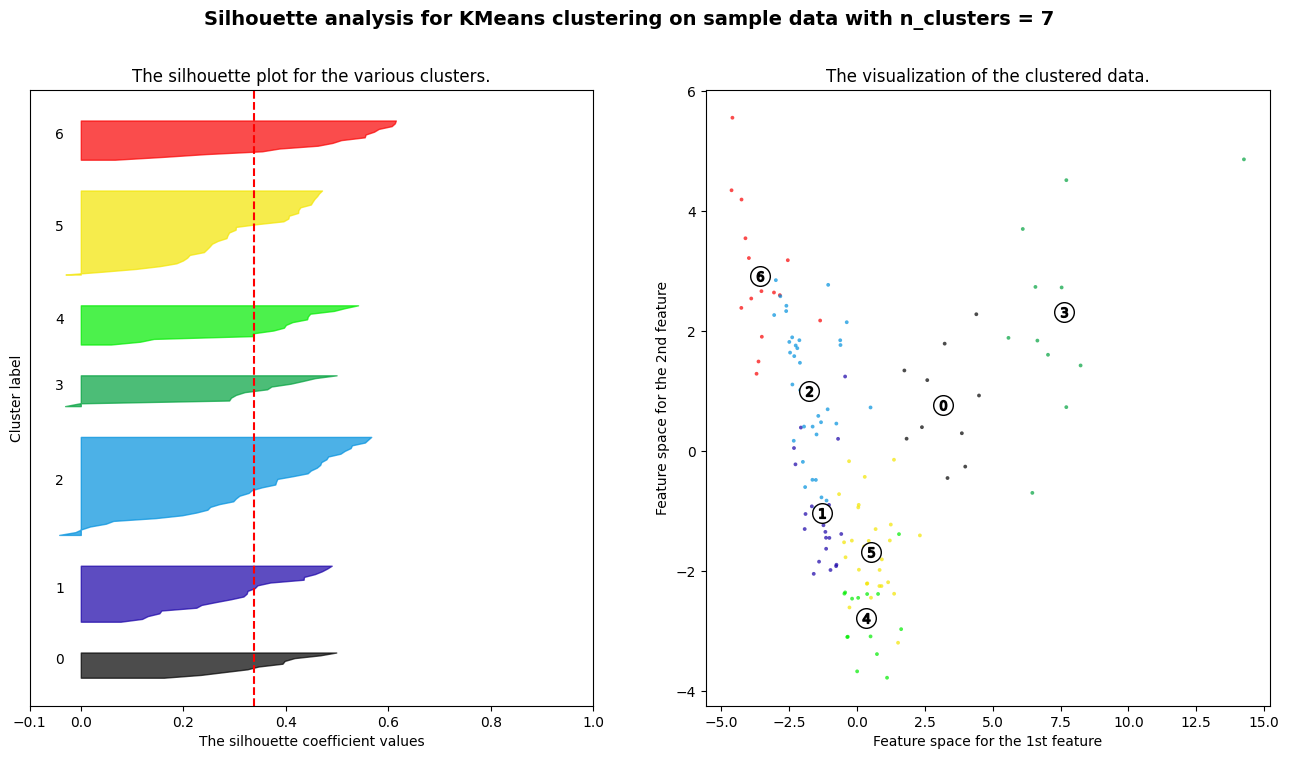

In [224]:
# Silhouette plots to determine optimal number of clusters: modified from lecture code
for n_clusters in range(2, 8):
    km = KMeans(n_clusters=n_clusters, random_state=42)
    clusterLabels = km.fit_predict(X_pca)
    avgSilOpt = silhouette_score(X_pca, clusterLabels)
    sampleSilVals = silhouette_samples(X_pca, clusterLabels)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sampleSilVals[clusterLabels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=avgSilOpt, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(clusterLabels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    f"with n_clusters = {n_clusters}"),
                    fontsize=14, fontweight='bold')

    plt.show()

In [225]:
# Group by cluster membership
X_km= X.copy()
X_km.drop(columns=catCols, inplace=True)
kmeans = KMeans(n_clusters=2, random_state=42)
clusterLabels = kmeans.fit_predict(X_pca)
X_km["Cluster"] = clusterLabels
X_km.groupby("Cluster").mean().T

Cluster,0,1
pct_attendance,8.981746e+01,9.089267e+01
pct_chronically_absent,3.083675e+01,3.067282e+01
total_population,5.306983e+03,3.953319e+03
median_income,8.083965e+04,3.418553e+04
white_pct,7.342341e+01,3.791697e+01
black_pct,6.046078e+00,2.597592e+01
american_indian_alaska_native_pct,1.507307e-01,4.803748e-01
asian_pct,1.160224e+01,1.430445e+01
hawaiian_pacific_islander_pct,4.790019e-02,5.889150e-02
multiple_race_pct,1.047129e+01,1.102981e+01


**Interpretation of Clustering Results**
The KMeans clustering mainly shows two different types of neighborhoods in New York City: Wealthier neighborhoods, predominantly White and higher property value areas with lower eviction rates; economically disadvantaged neighborhoods, racially diverse communities with lower property values and higher eviction rates. Two clusters were chosen based on the clearly superior average silhouette score and as identified in the silhouette and feature space plots.

1. Cluster 0 has much higher house sale prices than Cluster 1 on average, \$6410000 vs. \$1078000 in 2022. Cluster 0 also has much higher house value than Cluster 1, \$1.7M vs. 0.7M in 2022.
2. Cluster 0 has a far smaller number of evictions than Cluster 1 from 2019 to 2022.
3. Cluster 0 is more populous (~5,307) than Cluster 1 (~3,953).
4. White population is predominant in Cluster 0 (73.4%) but lower in Cluster 1 (37.9%). Black population is higher in Cluster 1 (25.9%) than in Cluster 0 (6.0%). Other racial categories, particularly "other race" (15.7%) and "American Indian/Alaska Native" (0.48%), are more represented in Cluster 1 than in Cluster 0 (3.5% and 0.15%, respectively). 

These clustering results reveal the relationship between socio-economic status and residential segregation in New York City neighborhoods. Wealthier neighborhoods tend to be predominantly White. Racially diverse neighborhoods tend to have lower median income and lower housing wealth. 

Overall, between the analysis in this part and previous parts, we see two distinct types of neighborhoods in NYC: 
- Wealthier, predominantly-white neighborhoods with higher property values and lower socioeconomic stress as identified by the lower eviction and schoolchild truancy rates.
- Economically disadvantaged, racially diverse neighborhoods with lower property values and higher socioeconomic stress (higher eviction counts and truancy rates).

In combination, this is useful for policymakers and urban planners to understand the factors that contribute to these issues and identify where to target interventions to improve the quality of life for NYC residents.
